 环境准备

In [32]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

数据准备

In [33]:
# 数据准备
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root="../data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="../data", train=False, download=True, transform=transform)

train_sizes = [100, 1000, 5000, 10000, 60000]
train_acc_list, test_acc_list = [], []


Logistic Regression 模型

In [34]:
# Logistic Regression 模型
class LogisticRegression(nn.Module):
    def __init__(self, in_dim=28*28, out_dim=10):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 展平
        return self.linear(x)

训练 + 测试函数

In [35]:
# 训练 + 测试函数
def train_eval(train_subset, test_loader, epochs=3, lr=0.1):
    model = LogisticRegression()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

    for _ in range(epochs):
        for x, y in train_loader:
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
    
    # 计算准确率
    def accuracy(loader):
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in loader:
                output = model(x)
                pred = output.argmax(dim=1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        return correct / total

    return accuracy(train_loader), accuracy(test_loader)


主循环

In [36]:
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

for size in train_sizes:
    subset = Subset(train_dataset, list(range(size)))
    train_acc, test_acc = train_eval(subset, test_loader)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(f"Train size {size}: Train acc={train_acc:.4f}, Test acc={test_acc:.4f}")

Train size 100: Train acc=0.8500, Test acc=0.5746
Train size 1000: Train acc=0.8500, Test acc=0.8016
Train size 5000: Train acc=0.8924, Test acc=0.8790
Train size 10000: Train acc=0.9010, Test acc=0.8936
Train size 60000: Train acc=0.9134, Test acc=0.9174


学习曲线可视化

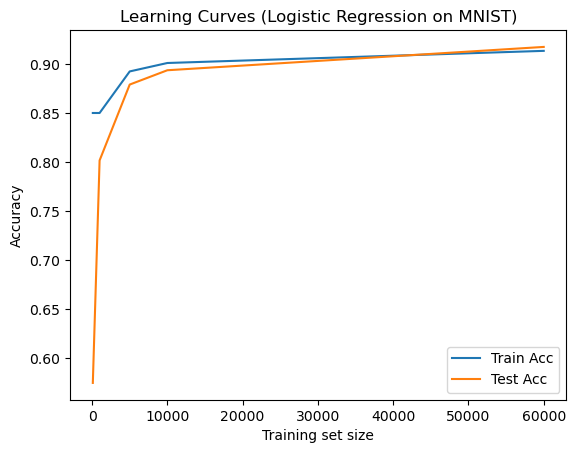

In [38]:
# 绘制学习曲线
plt.plot(train_sizes, train_acc_list, label="Train Acc")
plt.plot(train_sizes, test_acc_list, label="Test Acc")
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.title("Learning Curves (Logistic Regression on MNIST)")
plt.legend()
plt.show()

## 分析（Day8 学习曲线结论）
- 当训练集很小时（如 100 样本），模型几乎记住了数据，训练准确率 >0.85，但测试准确率仅 ~0.6，出现过拟合。
- 随着训练集增加到 1k–10k，测试准确率大幅提升到 ~0.9，训练和测试差距明显缩小，泛化能力增强。
- 当数据集扩展到 60k，全量数据下，训练和测试准确率都趋于稳定（~0.91–0.92），两条曲线几乎重合。
- 说明 Logistic Regression 在 MNIST 上的表现已经触顶：它的模型容量有限，即使有更多数据也难再提升，表现出一定程度的欠拟合。
- 后续如果要提升性能，需要换更复杂的模型（如 MLP、CNN）或增加正则化方法，而不仅仅是增加数据。


CNN实现
MNIST是一个简单数据集，用CNN大材小用了

Train size 100: Train acc=0.9700, Test acc=0.7342
Train size 1000: Train acc=1.0000, Test acc=0.9271
Train size 5000: Train acc=1.0000, Test acc=0.9729
Train size 10000: Train acc=1.0000, Test acc=0.9818
Train size 60000: Train acc=0.9993, Test acc=0.9907


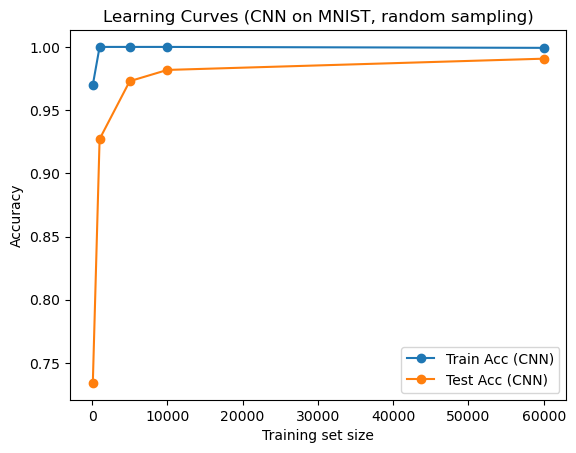

In [42]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import random

# 固定随机种子，保证结果可复现
random.seed(42)
torch.manual_seed(42)

# 数据准备
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root="../data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="../data", train=False, download=True, transform=transform)

train_sizes = [100, 1000, 5000, 10000, 60000]
train_acc_list, test_acc_list = [], []

# CNN 模型
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*14*14, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))             # (batch, 32, 28, 28)
        x = self.pool(self.relu(self.conv2(x)))  # (batch, 64, 14, 14)
        x = x.view(x.size(0), -1)                # 展平 → (batch, 12544)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 训练 + 测试函数
def train_eval(train_subset, test_loader, epochs=10, lr=0.001):
    model = SimpleCNN()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

    for _ in range(epochs):
        for x, y in train_loader:
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
    
    def accuracy(loader):
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in loader:
                output = model(x)
                pred = output.argmax(dim=1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        return correct / total

    return accuracy(train_loader), accuracy(test_loader)

# 主循环
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

for size in train_sizes:
    indices = random.sample(range(len(train_dataset)), size)  # 随机采样
    subset = Subset(train_dataset, indices)
    train_acc, test_acc = train_eval(subset, test_loader)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(f"Train size {size}: Train acc={train_acc:.4f}, Test acc={test_acc:.4f}")

# 学习曲线
plt.plot(train_sizes, train_acc_list, marker='o', label="Train Acc (CNN)")
plt.plot(train_sizes, test_acc_list, marker='o', label="Test Acc (CNN)")
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.title("Learning Curves (CNN on MNIST, random sampling)")
plt.legend()
plt.show()
